In [1]:
from __future__ import absolute_import, division, print_function, unicode_literals
import functools
from IPython.display import Image, clear_output

import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler, MinMaxScaler
import numpy as np
import tensorflow as tf
import pandas as pd
from data_info import *
from preprocessing_helpers import *
from datetime import datetime
%matplotlib inline
pd.set_option("display.precision", 2)
tf.random.set_seed(42)

In [2]:
new_cols = ['reanalysis_tdtr_k',
                   'station_diur_temp_rng_c',
                   'precipitation_amt_mm']
new_norm = [
                   'reanalysis_tdtr_k',
                   'station_diur_temp_rng_c',
                   'precipitation_amt_mm',
]

In [3]:
datasets, norm_scale = generate_lstm_data(train_file, single_step=True)

In [4]:
(sj_train_x, sj_train_y), (sj_val_x, sj_val_y) = datasets[0]
(iq_train_x, iq_train_y), (iq_val_x, iq_val_y) = datasets[1]

In [5]:
BATCH_SIZE = 16
BUFFER_SIZE = 100
train_sj_data_single = tf.data.Dataset.from_tensor_slices((sj_train_x, sj_train_y))
train_sj_data_single = train_sj_data_single.cache().shuffle(BUFFER_SIZE).batch(BATCH_SIZE).repeat()

val_sj_data_single = tf.data.Dataset.from_tensor_slices((sj_val_x, sj_val_y))
val_sj_data_single = val_sj_data_single.batch(BATCH_SIZE).repeat()

In [6]:
sj_train_x[0].shape

(6, 16)

In [7]:
# Build network with 
def build_model(optimizer = None):
  model = tf.keras.Sequential([
    tf.keras.layers.LSTM(32, input_shape=sj_train_x.shape[-2:]),
    tf.keras.layers.Dense(1)
  ])

  if not optimizer:
    optimizer = tf.keras.optimizers.RMSprop()

  model.compile(loss='mae',
                optimizer=optimizer,
                metrics=['mae'])
  return model


In [8]:
log_dir="logs/fit/lstm" + datetime.now().strftime("%Y%m%d-%H%M%S")
tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir=log_dir, histogram_freq=1)

# create model
# optimizer = tf.keras.optimizers.SGD(learning_rate=0.005, momentum=0.01, nesterov=False, name='SGD')
sj_model = build_model()

# Train the Model.
EVALUATION_INTERVAL = 200
EPOCHS = 10

# The patience parameter is the amount of epochs to check for improvement
early_stop = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=15)

reduce_lr = tf.keras.callbacks.ReduceLROnPlateau(monitor="val_loss", factor=0.8, patience=5, min_lr=1e-6, verbose=1,
                                                     mode="max")

history = sj_model.fit(
    train_sj_data_single,
    epochs=EPOCHS, 
    steps_per_epoch=EVALUATION_INTERVAL,
    validation_data = val_sj_data_single, 
    verbose=1,
    validation_steps=50,
    callbacks=[tensorboard_callback])

Train for 200 steps, validate for 50 steps
Epoch 1/10
200/200 [==============================] - 4s 19ms/step - loss: 32.0584 - mae: 32.2753 - val_loss: 17.0110 - val_mae: 17.5614
Epoch 2/10
200/200 [==============================] - 2s 9ms/step - loss: 27.4727 - mae: 27.6999 - val_loss: 16.2435 - val_mae: 16.7830
Epoch 3/10
200/200 [==============================] - 2s 9ms/step - loss: 24.9098 - mae: 25.0101 - val_loss: 15.6548 - val_mae: 16.3416
Epoch 4/10
200/200 [==============================] - 2s 9ms/step - loss: 23.8150 - mae: 24.0370 - val_loss: 15.7628 - val_mae: 16.4623
Epoch 5/10
200/200 [==============================] - 2s 8ms/step - loss: 24.5574 - mae: 24.7497 - val_loss: 16.6089 - val_mae: 17.1652
Epoch 6/10
200/200 [==============================] - 2s 9ms/step - loss: 23.9837 - mae: 24.1809 - val_loss: 16.3301 - val_mae: 16.9623
Epoch 7/10
200/200 [==============================] - 2s 9ms/step - loss: 23.2976 - mae: 23.4373 - val_loss: 15.8738 - val_mae: 16.6337
Epoc

In [9]:
for x, y in val_sj_data_single.take(1):
    print(x.numpy().shape)
    print(y.numpy().shape)
    print(sj_model.predict(x))

(16, 6, 16)
(16,)
[[29.140396]
 [29.04152 ]
 [28.502636]
 [28.475296]
 [28.08214 ]
 [27.77568 ]
 [26.93968 ]
 [26.945045]
 [27.944836]
 [27.943594]
 [22.224384]
 [27.047972]
 [27.644915]
 [27.752434]
 [20.993252]
 [15.270473]]


In [10]:
org_test_data, test_scale = generate_lstm_data(test_file_in, cols=CSV_COLUMNS_NO_LABEL + [DATETIME_COLUMN], single_step=True, train_frac=1.0, train_scale=norm_scale)
(sj_test_x, sj_test_y), = org_test_data[0]
(iq_test_x, iq_test_y), = org_test_data[1]
# val_set = tf.data.Dataset.from_tensor_slices((sj_val_x, sj_val_y))
# sj_test_set = val_set.concatenate(tf.data.Dataset.from_tensor_slices((sj_test_x, sj_test_y))).batch(1 + len(sj_val_y))
sj_test_set = tf.data.Dataset.from_tensor_slices((sj_test_x, sj_test_y)).batch(len(sj_test_y))

print(sj_test_x[0])
print(len(sj_test_y))
# print(sj_val_y)
# print(sj_val_x[0])
sj_pred = []
for x, y in sj_test_set.take(1):
#     print(x)
    predictions = sj_model.predict(x)
    sj_pred = predictions.flatten()
    print(len(predictions.flatten()))
# test_predictions = model.predict(org_test_data).flatten()

[[-0.79509535 -1.26376015 -1.33630091 -1.85464986 -1.50275558 -0.9260925
  -0.59271429 -1.96369749 -0.79509535 -1.81308259 -0.86069023 -1.17995419
  -1.12495713 -1.56874922 -0.26173096 -0.76572262]
 [-0.79509535 -1.41868    -1.50636384 -1.84918014 -1.26441291 -1.85433371
  -0.83156182 -1.6732169  -0.79509535 -1.80299656  2.72603001 -1.27083192
   0.34596776 -0.92873012 -1.32512837 -0.89916642]
 [-0.18414561 -1.77938889 -1.89926785 -1.91937487 -1.34386047 -2.24110088
  -0.64425804 -1.27914423 -0.18414561 -1.86259585  0.74616043 -1.38190471
  -1.15916469 -0.92873012 -0.99281668 -0.85468516]
 [-0.7092613  -0.87067995 -0.85543332 -1.19190216 -1.26441291 -0.61667877
  -0.75354205 -1.17470652 -0.7092613  -1.20883748  0.40183529 -0.53371251
   0.07230732 -0.5796288  -0.26173096 -0.89916642]
 [-0.41401012 -1.37359139 -1.40080754 -1.51279238 -1.58220313 -1.1581528
   0.12889819 -1.04828192 -0.41401012 -1.51600305 -0.6598339  -1.41219729
  -1.24468358 -1.27783145 -0.59404265  0.13416761]
 [-0.79

In [11]:
train_iq_data_single = tf.data.Dataset.from_tensor_slices((iq_train_x, iq_train_y))
train_iq_data_single = train_iq_data_single.cache().shuffle(BUFFER_SIZE).batch(BATCH_SIZE).repeat()

val_iq_data_single = tf.data.Dataset.from_tensor_slices((iq_val_x, iq_val_y))
val_iq_data_single = val_iq_data_single.batch(BATCH_SIZE).repeat()


iq_model = build_model()

history = iq_model.fit(
    train_iq_data_single,
    epochs=EPOCHS, 
    steps_per_epoch=EVALUATION_INTERVAL,
    validation_data = val_iq_data_single, 
    verbose=1,
    validation_steps=50,
    callbacks=[tensorboard_callback])

Train for 200 steps, validate for 50 steps
Epoch 1/10
200/200 [==============================] - 3s 14ms/step - loss: 5.6237 - mae: 5.6040 - val_loss: 6.7057 - val_mae: 7.6272
Epoch 2/10
200/200 [==============================] - 2s 9ms/step - loss: 5.0591 - mae: 5.0520 - val_loss: 6.9734 - val_mae: 7.9835
Epoch 3/10
200/200 [==============================] - 2s 9ms/step - loss: 4.7893 - mae: 4.7779 - val_loss: 7.4127 - val_mae: 8.1539
Epoch 4/10
200/200 [==============================] - 2s 9ms/step - loss: 4.4999 - mae: 4.5127 - val_loss: 7.6339 - val_mae: 8.4813
Epoch 5/10
200/200 [==============================] - 2s 9ms/step - loss: 4.3266 - mae: 4.3014 - val_loss: 7.7391 - val_mae: 8.4712
Epoch 6/10
200/200 [==============================] - 2s 9ms/step - loss: 4.1903 - mae: 4.1889 - val_loss: 7.9988 - val_mae: 8.5727
Epoch 7/10
200/200 [==============================] - 2s 9ms/step - loss: 4.0644 - mae: 4.0544 - val_loss: 7.9524 - val_mae: 8.7470
Epoch 8/10
200/200 [============

In [13]:
iq_test_set = tf.data.Dataset.from_tensor_slices((iq_test_x, iq_test_y)).batch(len(iq_test_y))
print(len(iq_test_y))
iq_pred = []
for x, y in iq_test_set.take(1):
    print(len(x))
    predictions = iq_model.predict(x)
    iq_pred = predictions.flatten()
    print(len(predictions.flatten()))
    
# print(pred)
# print(len(pred))

156
156
156


In [14]:
from preprocessing_helpers import export_test_to_csv
preds = np.concatenate((sj_pred, iq_pred), axis=None)
export_test_to_csv(predictions=preds)

416
asas


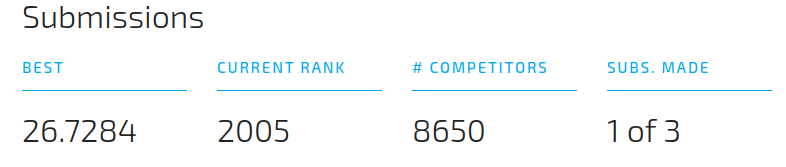

In [15]:
#Current Ranking (baseline)
Image("img/current-30-03.png")

In [77]:
# Tensorboard
# https://tensorboard.dev/experiment/rsdMubj0S165iOdLmbd13A/#scalars